In [1]:
#IMPORT LIBRARIES

In [2]:
import os; import pandas as pd; import numpy as np

In [3]:
#LOAD DATA

In [4]:
dataset = pd.read_csv('model_cm_60_r.csv')     #dataset with 60 variables
oot = pd.read_csv('out_of_sample_cm.csv')

backup = dataset
backup2 = oot

C:\Users\scienaptic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (722,771,787,788,924,933,940,949,1156) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\scienaptic\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (986,1155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [233]:
#START RUNNING CODE FROM HERE

dataset = backup
oot = backup2

In [234]:
#remove INF and NaNs, replace with special value

dataset = dataset.replace([np.inf, -np.inf], np.nan)
dataset = dataset.fillna(-999)
oot = oot.replace([np.inf, -np.inf], np.nan)
oot = oot.fillna(-999)

In [235]:
#select columns for data vs target
data = dataset.columns.intersection(oot.columns)
data = data.drop('target')  #remove target from training columns
data = data.drop('new_id')
data = data.drop('col3_colStatus')

In [236]:
#use dummy encoder to convert categorical variables to indicators

nonNumeric = data.drop(dataset[data].select_dtypes('number').columns)

dataNon = dataset[nonNumeric]
ootNon = oot[nonNumeric]

dataDummy = pd.get_dummies(dataNon)
ootDummy = pd.get_dummies(ootNon)

common = dataDummy.columns.intersection(ootDummy.columns) #to make sure they have the same columns
dataDummy = dataDummy[common] 
ootDummy = ootDummy[common]

In [237]:
#replace categorical variables with indicator variables 

dataset = dataset.drop(columns=nonNumeric)
oot = oot.drop(columns=nonNumeric)

dataset[dataDummy.columns] = dataDummy
oot[ootDummy.columns] = ootDummy

In [238]:
#update data then proceed to model

data = dataset.columns.intersection(oot.columns)
data = data.drop(['target', 'new_id', 'col3_colStatus'])

In [239]:
#sanity check

dataset.shape 

(36709, 1847)

In [604]:
#perform feature selection

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [605]:
lsvc = LinearSVC(C=0.0002, penalty="l1", dual=False, random_state=42).fit(dataset[data], dataset['target'])
select = SelectFromModel(lsvc, prefit=True)

In [606]:
datareduced = select.transform(dataset[data])
datareduced.shape

(36709, 135)

In [607]:
#   4-STEP MODELLING PROCESS: IMPORT WHICH MODEL, MAKE INSTANCE OF MODEL, TRAIN USING FIT, PREDICT LABELS OF TESTDATA

In [608]:
import sklearn.linear_model as skl

In [609]:
logit = skl.LogisticRegression(penalty='l1', random_state=42, C=0.001)

In [610]:
# model = logit.fit(dataset[data], dataset['target'])
model = logit.fit(datareduced, dataset['target'])

In [620]:
#assign data for testing

test = dataset

testData = select.transform(test[data])
testTarget = test['target']

In [621]:
prediction = model.predict_proba(testData)[:,1]     #predict probabilities, for ROC and KS

In [622]:
#EVALUATE MODEL USING METRICS

In [623]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr, tpr, threshold = roc_curve(testTarget, prediction) 
roc_auc = auc(fpr,tpr)
roc_auc_score(testTarget, prediction)

0.728752252913888

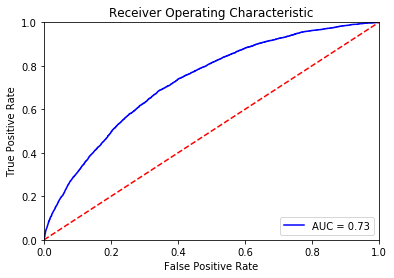

In [624]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [625]:
predictLabels = model.predict(testData)    #predict labels directly, for accuracy_score

In [626]:
from sklearn.metrics import accuracy_score
accuracy_score(testTarget, predictLabels)

0.8777411533956251

In [627]:
def rnkOrdering(data, bad_col, score_col, n_bkts):
    data['bucket'] = pd.qcut(data[score_col], n_bkts, duplicates='drop')
    grouped = data.groupby('bucket', as_index = True)
    agg1 = grouped[score_col].min()
    agg2 = grouped[score_col].max()
    agg3 = grouped[bad_col].count()
    agg4 = grouped[bad_col].sum()
    agg5 = np.round(grouped[score_col].mean()*100,2)
    
    ret_tbl = pd.DataFrame({"min_score":agg1, "max_score":agg2, "total":agg3, "Bads":agg4, "Mean_Score":agg5})
    ret_tbl["Goods"] = ret_tbl["total"] - ret_tbl["Bads"]
    ret_tbl["Bad_Rate"] = np.round(ret_tbl["Bads"]/ret_tbl["total"], 4)*100
    ret_tbl = ret_tbl.sort_index(axis=0, ascending=False)
    ret_tbl.index = range(n_bkts)
    
    ret_tbl["Cum_Bad"] = np.round((ret_tbl.Bads / ret_tbl.Bads.sum()).cumsum(), 4)*100
    ret_tbl["Cum_Good"] = np.round((ret_tbl.Goods / ret_tbl.Goods.sum()).cumsum(), 4)*100
    ret_tbl['KS'] = np.abs(ret_tbl["Cum_Bad"] - ret_tbl["Cum_Good"])
    
    gini = ret_tbl["Cum_Bad"][0]*ret_tbl["Cum_Good"][0]/(2*100*100)
    for i in range(1,n_bkts):
        gini += (ret_tbl["Cum_Bad"][i] + ret_tbl["Cum_Bad"][i-1])*(ret_tbl["Cum_Good"][i] - 
                                                                   ret_tbl["Cum_Good"][i-1])/(2*100*100)
    gini = np.round(2.*gini - 1., 4)*100
    
    ks = np.round(ret_tbl.KS.max(), 2)
    
    coltitles = ["min_score", "max_score", "Mean_Score", "total", "Goods", "Bads", "Bad_Rate", "Cum_Bad", "KS"]
    
    return ret_tbl[coltitles], {"Gini":gini, "KS":ks}

In [628]:
testDF = pd.DataFrame(testData)
testDF['Bad'] = testTarget
testDF['Pred_Prob'] = prediction

print(rnkOrdering(testDF, "Bad", "Pred_Prob", 10))

(   min_score  max_score  Mean_Score  total  Goods  Bads  Bad_Rate  Cum_Bad  \
0   0.236722   0.968480       32.60   3671   2471  1200     32.69    26.61   
1   0.177421   0.236719       20.33   3671   2914   757     20.62    43.39   
2   0.144363   0.177407       15.96   3671   3000   671     18.28    58.27   
3   0.120241   0.144362       13.18   3671   3155   516     14.06    69.71   
4   0.100701   0.120239       11.02   3670   3279   391     10.65    78.38   
5   0.083956   0.100697        9.22   3671   3341   330      8.99    85.70   
6   0.067632   0.083954        7.59   3671   3413   258      7.03    91.42   
7   0.051490   0.067630        5.96   3671   3476   195      5.31    95.74   
8   0.035815   0.051488        4.39   3671   3557   114      3.11    98.27   
9   0.002128   0.035814        2.57   3671   3593    78      2.12   100.00   

      KS  
0  18.94  
1  26.67  
2  32.23  
3  33.87  
4  32.36  
5  29.30  
6  24.42  
7  17.95  
8   9.43  
9   0.00  , {'Gini': 45.03, 'K